# Data Science: Example using ScalaPy
Python boasts a plethora of robust libraries tailored for data science, ranging from data manipulation tools like pandas and xarray to visualization libraries such as matplotlib. In this notebook, we will explore how to harness these powerful Python libraries from Scala in a secure and type-safe manner, utilizing the state-of-the-art ScalaPy library to bridge between the two ecosystems seamlessly.

In [1]:
import $ivy.`dev.scalapy::scalapy-core:0.5.3`

Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-core_2.13/0.5.3/scalapy-core_2.13-0.5.3.pom
Downloaded https://repo1.maven.org/maven2/sh/almond/almond-scalapy_2.13/0.14.0-RC14/almond-scalapy_2.13-0.14.0-RC14.pom
Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-macros_2.13/0.5.3/scalapy-macros_2.13-0.5.3.pom
Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-macros_2.13/0.5.3/scalapy-macros_2.13-0.5.3-sources.jar
Downloaded https://repo1.maven.org/maven2/sh/almond/almond-scalapy_2.13/0.14.0-RC14/almond-scalapy_2.13-0.14.0-RC14-sources.jar
Downloaded https://repo1.maven.org/maven2/sh/almond/almond-scalapy_2.13/0.14.0-RC14/almond-scalapy_2.13-0.14.0-RC14.jar
Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-macros_2.13/0.5.3/scalapy-macros_2.13-0.5.3.jar
Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-core_2.13/0.5.3/scalapy-core_2.13-0.5.3-sources.jar
Downloaded https://repo1.maven.org/maven2/dev/scalapy/scalapy-core_2.13/0.

import $ivy.$

In [2]:
import me.shadaj.scalapy.py
import py.PyBracketAccess
import py.PyQuote
import me.shadaj.scalapy.py.SeqConverters

import me.shadaj.scalapy.py
import py.PyBracketAccess
import py.PyQuote
import me.shadaj.scalapy.py.SeqConverters

In [3]:
/** give access to the underlying python type. 
 * it can be useful for writing facade with different name w.r.t. the python code
*/
trait PythonInternals {
  self: py.Any =>

  protected[this] lazy val underlying = this.as[py.Dynamic]
}

defined trait PythonInternals

In [4]:
/**
 * Example of a facade for the matplotlib.pyplot module
 * This is just a simple example and it is not a full implementation of the module
 */
object Matplotlib extends py.StaticModule("matplotlib.pyplot") with PythonInternals {
  private val io = py.module("io")
  def show(): Svg = { // workaround to plot graph in almond jupyter
    val svg_buffer = io.BytesIO()
    underlying.savefig(svg_buffer, format="svg")
    svg_buffer.seek(0)
    Svg(svg_buffer.getvalue().decode("utf-8").as[String])
  }

  def popUpShow(): Unit = underlying.show() // Open a new window with the plot
  
  def gcf(): py.Any =
    underlying.gcf()

}

defined object Matplotlib

In [5]:
/** 
 * Example of a facade for the pandas module
 */

/* Enumeration for supported plots */
sealed abstract class PlotKind(val kind: String)
case object Line extends PlotKind("line")
case object Box extends PlotKind("bar")

/**
 * Some useful methods for the PandasDataframe facade
 */
@py.native
trait PandasDataframe extends py.Any with PythonInternals {
    def head(n: Int = 5): PandasDataframe = py.native
    def plot(kind: PlotKind): py.Any = underlying.plot(kind=kind.kind)
    def plot(kind: PlotKind, x: String): py.Any = underlying.plot(kind=kind.kind, x=x, rot=0)
    def drop(labels: String*): PandasDataframe = underlying.drop(columns=labels.toPythonCopy).as[PandasDataframe]
    @PyBracketAccess
    def apply(column: String): PandasDataframe = py.native
    @PyBracketAccess
    def apply(columns: String*): PandasDataframe = py"$underlying[${columns.toPythonCopy}]".as[PandasDataframe]
    @PyBracketAccess
    def sortValues(by: String, ascending: Boolean = true): PandasDataframe = underlying.sort_values(by=by, ascending=ascending).as[PandasDataframe]
    def to_html(): Html = Html(underlying.to_html().as[String])
}

defined class PlotKind
defined object Line
defined object Box
defined trait PandasDataframe

In [6]:
/** 
 * Facade for Pandas module and its plotting submodule
 */
@py.native
trait PandasPlotting extends py.Any with PythonInternals {
    def scatterMatrix(dataframe: PandasDataframe, alpha: Double = 0.2): py.Any = underlying.scatter_matrix(dataframe, alpha=alpha)
}

@py.native
object Pandas extends py.StaticModule("pandas") with PythonInternals {
    def readCsv(path: String): PandasDataframe = underlying.read_csv(path).as[PandasDataframe]
    def plotting(): PandasPlotting = underlying.plotting.as[PandasPlotting]
}

defined trait PandasPlotting
defined object Pandas

In [7]:
val df = Pandas.readCsv("2017.csv").drop("Happiness[R]", "Whisker[h]", "Whisker[l]", "Dystopia.Residual")
df.head(5)

df: PandasDataframe =                       Country  Happiness[S]       GDP    Family  Life.Expectancy.   Freedom  Generosity  Corruption.
0                      Norway         7.537  1.616463  1.533524          0.796667  0.635423    0.362012     0.315964
1                     Denmark         7.522  1.482383  1.551122          0.792566  0.626007    0.355280     0.400770
2                     Iceland         7.504  1.480633  1.610574          0.833552  0.627163    0.475540     0.153527
3                 Switzerland         7.494  1.564980  1.516912          0.858131  0.620071    0.290549     0.367007
4                     Finland         7.469  1.443572  1.540247          0.809158  0.617951    0.245483     0.382612
..                        ...           ...       ...       ...               ...       ...         ...          ...
150                    Rwanda         3.471  0.368746  0.945707          0.326425  0.581844    0.252756     0.455220
151                     Syria         3.46

In [8]:
df.head(5).to_html()

,Country,Happiness[S],GDP,Family,Life.Expectancy.,Freedom,Generosity,Corruption.
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612


In [9]:
df("Country") // df["Country"]

res9: PandasDataframe = 0                        Norway
1                       Denmark
2                       Iceland
3                   Switzerland
4                       Finland
                 ...           
150                      Rwanda
151                       Syria
152                    Tanzania
153                     Burundi
154    Central African Republic
Name: Country, Length: 155, dtype: object

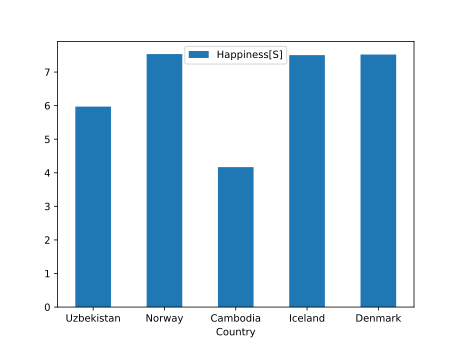

res10_0: py.Any = Axes(0.125,0.11;0.775x0.77)

In [10]:
df.sortValues("Freedom", false)("Country", "Happiness[S]").head(5).plot(Box, x="Country")
Matplotlib.show()

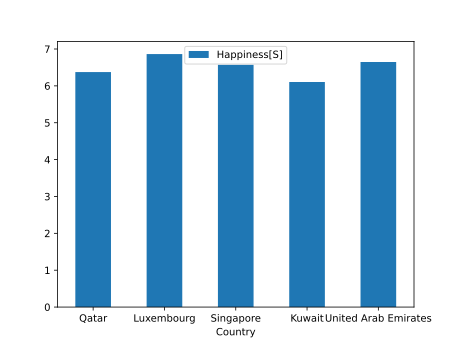

res11_0: py.Any = Axes(0.125,0.11;0.775x0.77)

In [11]:
df.sortValues("GDP", false)("Country", "Happiness[S]").head(5).plot(Box, x="Country")
Matplotlib.show()

cell13.sc:1: Auto-application to `()` is deprecated. Supply the empty argument list `()` explicitly to invoke method plotting,
or remove the empty argument list from its definition (Java-defined methods are exempt).
In Scala 3, an unapplied method like this will be eta-expanded into a function. [quickfixable]
val res13_0 = Pandas.plotting.scatterMatrix(df.drop("Country"), alpha=0.2)
                     ^


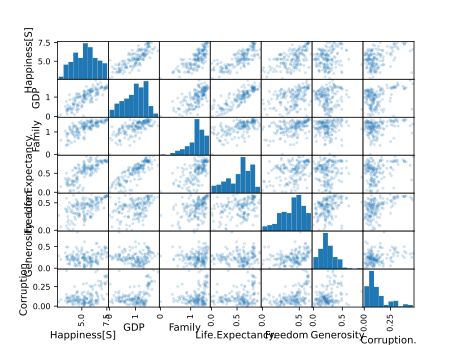

res13_0: py.Any = [[<Axes: xlabel='Happiness[S]', ylabel='Happiness[S]'>
  <Axes: xlabel='GDP', ylabel='Happiness[S]'>
  <Axes: xlabel='Family', ylabel='Happiness[S]'>
  <Axes: xlabel='Life.Expectancy.', ylabel='Happiness[S]'>
  <Axes: xlabel='Freedom', ylabel='Happiness[S]'>
  <Axes: xlabel='Generosity', ylabel='Happiness[S]'>
  <Axes: xlabel='Corruption.', ylabel='Happiness[S]'>]
 [<Axes: xlabel='Happiness[S]', ylabel='GDP'>
  <Axes: xlabel='GDP', ylabel='GDP'>
  <Axes: xlabel='Family', ylabel='GDP'>
  <Axes: xlabel='Life.Expectancy.', ylabel='GDP'>
  <Axes: xlabel='Freedom', ylabel='GDP'>
  <Axes: xlabel='Generosity', ylabel='GDP'>
  <Axes: xlabel='Corruption.', ylabel='GDP'>]
 [<Axes: xlabel='Happiness[S]', ylabel='Family'>
  <Axes: xlabel='GDP', ylabel='Family'>
  <Axes: xlabel='Family', ylabel='Family'>
  <Axes: xlabel='Life.Expectancy.', ylabel='Family'>
  <Axes: xlabel='Freedom', ylabel='Family'>
  <Axes: xlabel='Generosity', ylabel='Family'>
  <Axes: xlabel='Corruption.', ylab

In [13]:
Pandas.plotting.scatterMatrix(df.drop("Country"), alpha=0.2)
Matplotlib.show()

// Python operation from scala
py.Dynamic.global.len(pythonList)